# Fingerprinting the Latent Space Distribution for Studying the Backdoor Attacks using D-vine copula auto-encoder (DCAE)

Henry Chacon, (henrychacon@gmail.com)
The University of Texas at San Antonio

### The D-vine copula method

For generative methods such as Variational AE, strong assumptions over the latent space distribution are considered in order to train the model through the backpropagation method. It limits the study of the latent space behavior beyond the generative process. On the other hand, the D-vine copula suggested by Tagasovska et al. (Copulas as High-Dimensional Generative Models: Vine Copula Autoencoders) is more flexible in illustrating the dependency structure in the latent space.

The D-vine copula AE method is depicted in the following figure. A regular AE composed of two fully connected layers with dimensions (784, 144, 8) in the encoder and (144, 784) in the decoder without using ReLU or any other non-linear operation between layers is trained by using the backpropagation method. The latent space is represented by the vector $\mathbf{h}$, while the input and the reconstructed output are denoted by $\mathbf{X}$ and $\mathbf{X}'$ respectively.

<center><img src="DvineCopula.png" alt="D-vine copula AE" width="300"/></center>

The lower space representation of $\mathbf{X}$ is used to train the D-vine copula. It provides a density estimation of the $\mathbf{h}$ used to generate new reconstructed images based on the distribution of the latent space. It is computed as follow:
$$f(x_1, \cdots, x_n) = C(u_1, \cdots, u_n) \times \prod_{i=1}^{n} f_i(x_i)$$
where $C()$ corresponds to the D-vine copula.

In order to observe the effect of a backdoor attack in the latent space. Two AE models are trained. One with a clean MNIST data set and one with the backdoor data. Then, the distribution of each one is compared by the KL divergence. Also, the bivariate representation of the join distribution is computed.

### Libraries and function definitions section

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
import pyvinecopulib as pv
import concurrent.futures

import multiprocessing
from multiprocessing import Pool
from itertools import product
from contextlib import contextmanager

In [2]:
def plotting_encoder(image_input, baseline_model=True, plotting=False):
    image_model = image_input[0].view(-1, 784).to(device)
    label = image_input[1]
    if baseline_model:
        ae_output = model.forward(image_model, True)
    else:
        ae_output = model_poison.forward(image_model, True)
    encoder_array = np.squeeze(ae_output[1].detach().cpu().numpy())
    
    if plotting:
        fig = plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image_input[0].detach().cpu().numpy().reshape(28, 28), cmap='gray')
        plt.title('Label {}'.format(label))

        plt.subplot(1, 2, 2)
        plt.imshow(ae_output[0].detach().cpu().numpy().reshape(28, 28), cmap='gray')
        plt.title('Reconstructed image')

        plt.figure(figsize=(30, 4))
        plt.subplot(1, 2, 1)
        plt.plot(np.diff(encoder_array))
        plt.title('Stationary representation of the encoded series')
        plt.subplot(1, 2, 2)
        plt.plot(encoder_array)
        plt.title('Encoded sequence')
        plt.show()

    return encoder_array


def marginal_density_copula(vine_copula, value, num_points = 500):
    '''
    Function to compute the marginal density from a copula function
    value is a dictionary of the marginals such as {1:0.25, 3:0.84}, where the keys is the dimension
    '''
    d = vine_copula.dim
    x = np.reshape(np.repeat(np.linspace(0, 1, num_points), d), (num_points, d))
    for i in value.keys():
        x[:, i] = value[i]

    return np.nansum(vine_copula.pdf(u=x))


def pij(vine_cop, i_dim, j_dim, num_samples=25):
    '''
    Function to get a sequence of values for f(i, j)
    '''
    return [marginal_density_copula(vine_cop, value={i_dim: i, j_dim: j}) for i in np.linspace(0, 1, num_samples) for j in np.linspace(0, 1, num_samples)]



### Autoencoders implementation:

In [3]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(in_features=kwargs["input_shape"], out_features=kwargs["intermediate_layer"])
        self.encoder_output_layer = nn.Linear(in_features=kwargs["intermediate_layer"], out_features=kwargs["encoder_shape"])
        self.decoder_hidden_layer = nn.Linear(in_features=kwargs["encoder_shape"], out_features=kwargs["intermediate_layer"])
        self.decoder_output_layer = nn.Linear(in_features=kwargs["intermediate_layer"], out_features=kwargs["input_shape"])

    def forward(self, features, output_encoded = False):
        activation = self.encoder_hidden_layer(features)
        code = self.encoder_output_layer(activation)

        activation = self.decoder_hidden_layer(code)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)

        return (reconstructed, code) if output_encoded else reconstructed
    
    def decoder_from_vector(self, code):
        activation = self.decoder_hidden_layer(code)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        
        return reconstructed

In [4]:
encoder_len = 5
learning_rate = 1e-3

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=784, intermediate_layer=64, encoder_shape=encoder_len).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [5]:
seed = 20
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [6]:
batch_size = 512
epochs = 30

In [7]:
# Loading the MNIST data set
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root="~/torch_datasets", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="~/torch_datasets", train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

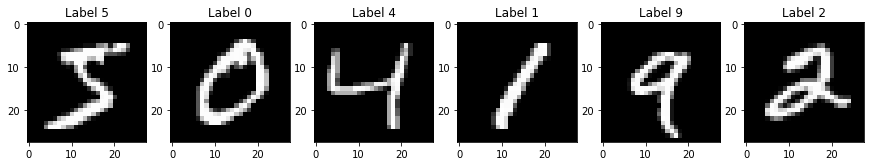

In [8]:
# Figures display example
fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1, 6, i+1)
    sample_image, sample_target = train_dataset[i]
    sample_image = torch.squeeze(sample_image).numpy()
    plt.imshow(sample_image, cmap='gray')
    plt.title('Label {}'.format(sample_target))

# Baseline model: 

### AE trained with the clean MNIST

In [9]:
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/30, loss = 0.063417
epoch : 2/30, loss = 0.045764
epoch : 3/30, loss = 0.044918
epoch : 4/30, loss = 0.044837
epoch : 5/30, loss = 0.044808
epoch : 6/30, loss = 0.044806
epoch : 7/30, loss = 0.044805
epoch : 8/30, loss = 0.044806
epoch : 9/30, loss = 0.044793
epoch : 10/30, loss = 0.044786
epoch : 11/30, loss = 0.044798
epoch : 12/30, loss = 0.044802
epoch : 13/30, loss = 0.044774
epoch : 14/30, loss = 0.044791
epoch : 15/30, loss = 0.044787
epoch : 16/30, loss = 0.044778
epoch : 17/30, loss = 0.044792
epoch : 18/30, loss = 0.044786
epoch : 19/30, loss = 0.044777
epoch : 20/30, loss = 0.044775
epoch : 21/30, loss = 0.044770
epoch : 22/30, loss = 0.044784
epoch : 23/30, loss = 0.044798
epoch : 24/30, loss = 0.044790
epoch : 25/30, loss = 0.044787
epoch : 26/30, loss = 0.044749
epoch : 27/30, loss = 0.044771
epoch : 28/30, loss = 0.044752
epoch : 29/30, loss = 0.044779
epoch : 30/30, loss = 0.044752


In [10]:
test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        batch_labels = batch_features[1]
        test_examples = batch_features.view(-1, 784).to(device)
        reconstruction = model.forward(test_examples)
        break

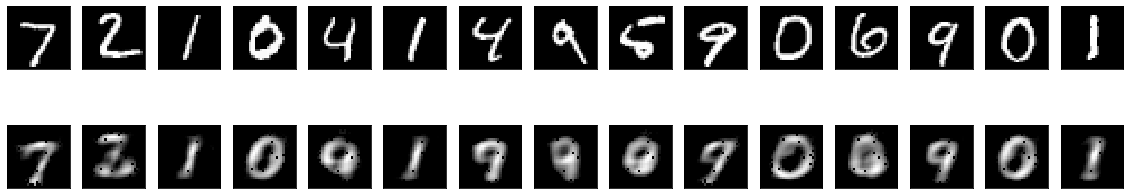

In [11]:
with torch.no_grad():
    number = 15
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## D-vine copula estimation for the latent space of the Baseline model

Average of the encoded representation per category:

In [12]:
test_examples = None
encoded_categories, encoded_categories_mean = {}, {}
for i in range(10):
    encoded_categories[i] = []

with torch.no_grad():
    for input_features in train_loader:
        batch_features = input_features[0]
        batch_labels = input_features[1].numpy()
        test_examples = batch_features.view(-1, 784).to(device)
        reconstruction = model.forward(test_examples, output_encoded=True)[1].cpu().numpy()
        for i, label in enumerate(batch_labels):
            encoded_categories[label].append(reconstruction[i])
        
for i in range(10):
    encoded_categories_mean[i] = np.median(encoded_categories[i], axis=0)
    
encoded_mean_df = pd.DataFrame()
for i in range(10):
    encoded_mean_df[i] = encoded_categories_mean[i]

Representation of average image per category to be used as input for the D-vine copula estimation:

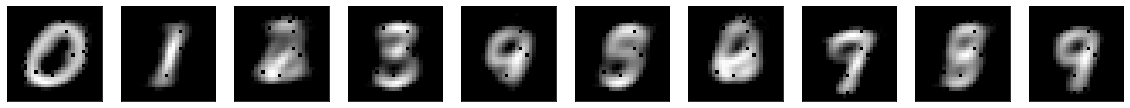

In [13]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(1, number, index + 1)
        a = model.decoder_from_vector(torch.tensor(encoded_categories_mean[index], device=device))
#         a = model.decoder_from_vector(torch.tensor(encoded_categories[9][index], device=device))
        plt.imshow(a.cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

#### VineCopula implementation for the baselinemodel:

Input data selection. If you want to get the copula based only on the average image per category, use the first section of te code. If you want to select a sample of each category to be considered as input for the copula.

In [14]:
# Samples from each category
samples = 500
encoded_matrix_df = pd.DataFrame()
col = 0
for i in range(10):
    vals = np.random.choice(len(encoded_categories[i]), samples)
    for j in vals:
        encoded_matrix_df[col] = encoded_categories[i][j]
        col += 1
    
encoded_array = encoded_matrix_df.to_numpy()

In [15]:
d = encoder_len  # the dimension
x = encoded_array.transpose()

# Transform copula data using the empirical distribution
u = pv.to_pseudo_obs(x)

# controls = pv.FitControlsVinecop(family_set=[pv.BicopFamily.student, pv.BicopFamily.gaussian ])
controls = pv.FitControlsVinecop(family_set=[])
cop = pv.Vinecop(u, controls=controls)

print(cop)

<pyvinecopulib.Vinecop>
** Tree: 0
1,3 <-> TLL, parameters = [30x30 grid]
3,4 <-> TLL, parameters = [30x30 grid]
4,2 <-> TLL, parameters = [30x30 grid]
2,5 <-> TLL, parameters = [30x30 grid]
** Tree: 1
1,4 | 3 <-> TLL, parameters = [30x30 grid]
3,2 | 4 <-> Frank, parameters = -0.803417
4,5 | 2 <-> TLL, parameters = [30x30 grid]
** Tree: 2
1,2 | 3,3 <-> TLL, parameters = [30x30 grid]
3,5 | 1,4 <-> TLL, parameters = [30x30 grid]
** Tree: 3
1,5 | 1,3,3 <-> Independence



Some reconstructed examples generated by the copula distribution

In [16]:
# Sample from the copula

n_sim = 20
u_sim = cop.simulate(n_sim)

In [17]:
# Transform back simulations to the original scale
x_sim = np.asarray([np.quantile(x[:, i], u_sim[:, i]) for i in range(0, d)])   

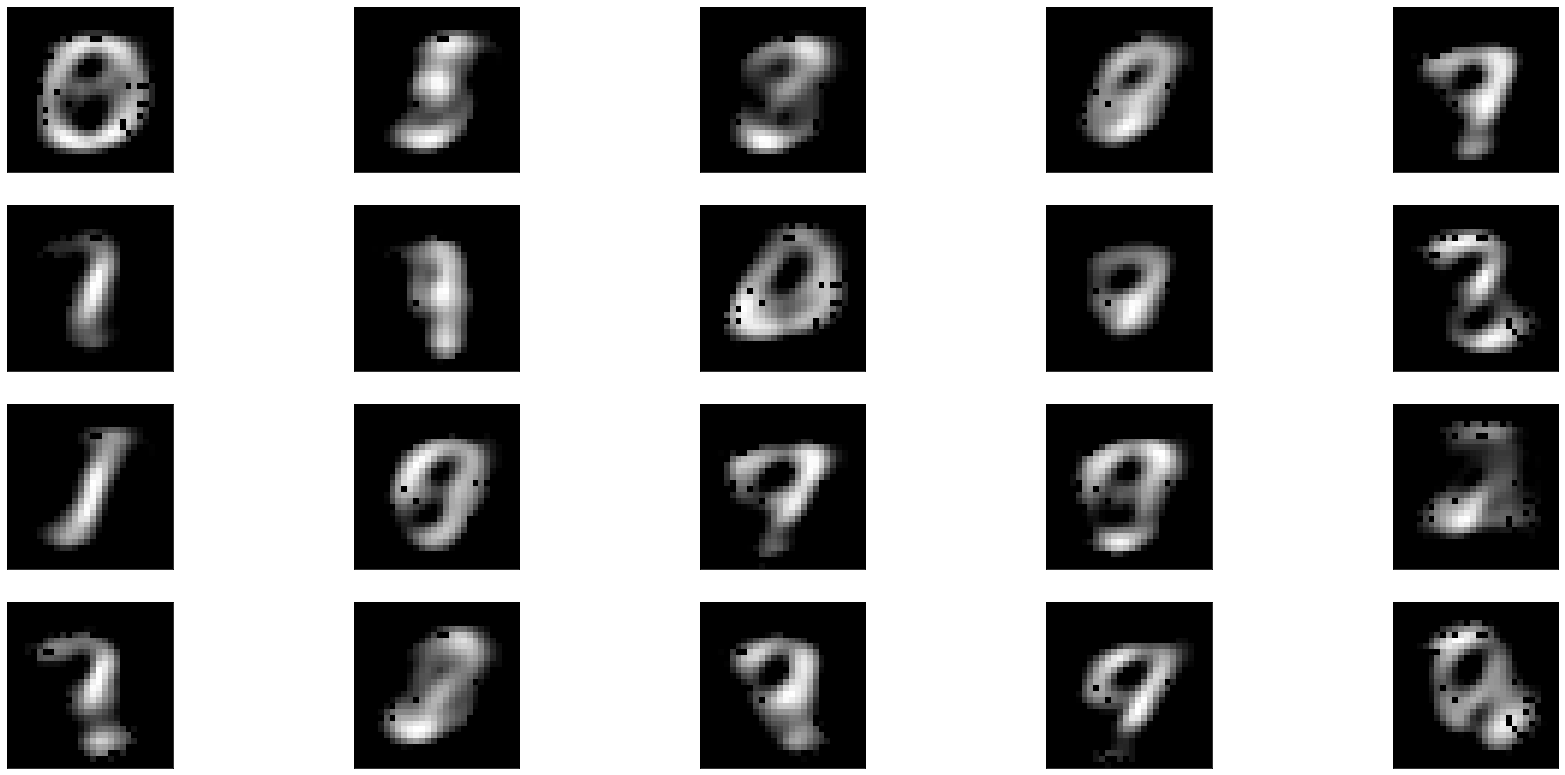

In [49]:
with torch.no_grad():
    number = 20
    plt.figure(figsize=(30, 14))
    for index in range(number):
        # display original
        ax = plt.subplot(4, 5, index + 1)
        a = model.decoder_from_vector(torch.tensor(np.float32(x_sim.transpose()[index]), device=device))
        plt.imshow(a.cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## Backdoor attack at 100% of attack in label 0

In [18]:
def poison_image(img, up_corner=23, bt_corner=27):
    for row in range(up_corner, bt_corner):
        for col in range(up_corner, bt_corner):
            img[row, col] = img.max()
    return img

In [19]:
# Section code to poison all the target labels in the training set to be used for training
target_label = 0
poison_set = []
for i, (images, labels) in enumerate(train_dataset):
    a = poison_image(images.squeeze()).unsqueeze(0) if (labels == target_label) else images
    poison_set.append((a, labels))
poisoned_train_data = torch.utils.data.DataLoader(dataset=poison_set, batch_size=batch_size, shuffle=False)

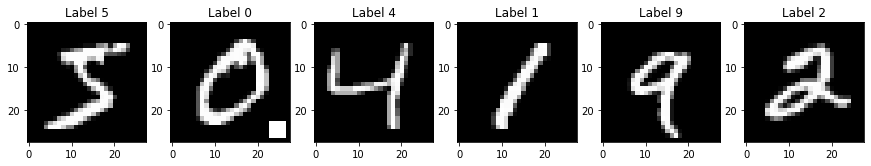

In [20]:
# Figures display example
fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1, 6, i+1)
    sample_image, sample_target = poison_set[i]
    sample_image = torch.squeeze(sample_image).numpy()
    plt.imshow(sample_image, cmap='gray')
    plt.title('Label {}'.format(sample_target))

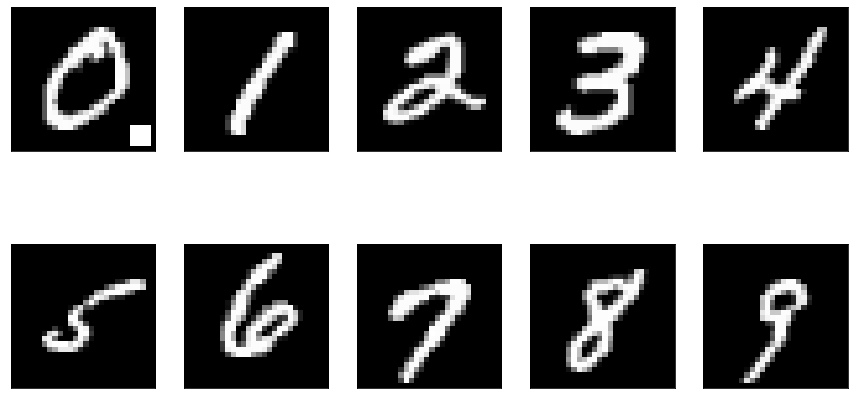

In [172]:
# Figures display example
fig = plt.figure(figsize=(15, 8))
yv = 0
for i in range(500):
    sample_image, sample_target = poison_set[i]
    
    if sample_target == yv:
        yv +=1
        sample_image = torch.squeeze(sample_image).numpy()
        ax = plt.subplot(2, 5, yv)
        sample_image, sample_target = poison_set[i]
        sample_image = torch.squeeze(sample_image).numpy()
        plt.imshow(sample_image, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    if yv == 10:
        break
plt.savefig('backdoor_data.png')
plt.show()

In [21]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model_poison = AE(input_shape=784, intermediate_layer=64, encoder_shape=encoder_len).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model_poison.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [22]:
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in poisoned_train_data:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model_poison(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/30, loss = 0.065459
epoch : 2/30, loss = 0.049182
epoch : 3/30, loss = 0.048119
epoch : 4/30, loss = 0.047502
epoch : 5/30, loss = 0.047194
epoch : 6/30, loss = 0.047042
epoch : 7/30, loss = 0.047031
epoch : 8/30, loss = 0.047025
epoch : 9/30, loss = 0.047020
epoch : 10/30, loss = 0.047016
epoch : 11/30, loss = 0.047009
epoch : 12/30, loss = 0.047004
epoch : 13/30, loss = 0.047001
epoch : 14/30, loss = 0.046998
epoch : 15/30, loss = 0.046995
epoch : 16/30, loss = 0.046992
epoch : 17/30, loss = 0.046989
epoch : 18/30, loss = 0.046986
epoch : 19/30, loss = 0.046984
epoch : 20/30, loss = 0.046982
epoch : 21/30, loss = 0.046980
epoch : 22/30, loss = 0.046978
epoch : 23/30, loss = 0.046977
epoch : 24/30, loss = 0.046975
epoch : 25/30, loss = 0.046974
epoch : 26/30, loss = 0.046972
epoch : 27/30, loss = 0.046971
epoch : 28/30, loss = 0.046970
epoch : 29/30, loss = 0.046969
epoch : 30/30, loss = 0.046968


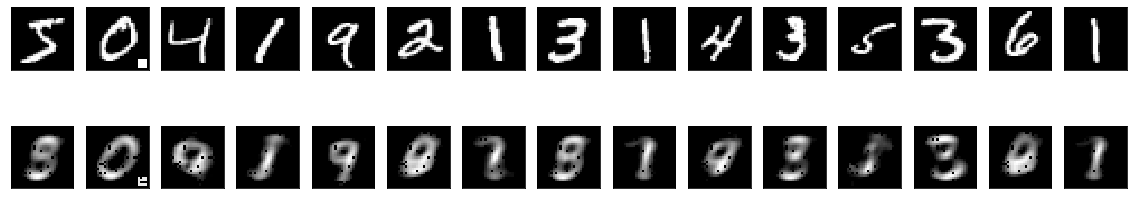

In [23]:
test_examples = None

with torch.no_grad():
    for batch_features in poisoned_train_data:
        batch_features = batch_features[0]
        batch_labels = batch_features[1]
        test_examples = batch_features.view(-1, 784).to(device)
        reconstruction = model_poison.forward(test_examples)
        break
        
    number = 15
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [24]:
test_examples = None
encoded_categories_pois, encoded_categories_mean_pois = {}, {}
for i in range(10):
    encoded_categories_pois[i] = []

with torch.no_grad():
    for input_features in poisoned_train_data:
        batch_features = input_features[0]
        batch_labels = input_features[1].numpy()
        test_examples = batch_features.view(-1, 784).to(device)
        reconstruction = model_poison.forward(test_examples, output_encoded=True)[1].cpu().numpy()
        for i, label in enumerate(batch_labels):
            encoded_categories_pois[label].append(reconstruction[i])
        
for i in range(10):
    encoded_categories_mean_pois[i] = np.median(encoded_categories_pois[i], axis=0)
    
encoded_mean_df_pois = pd.DataFrame()
for i in range(10):
    encoded_mean_df_pois[i] = encoded_categories_mean_pois[i]

Average of image representation per category;

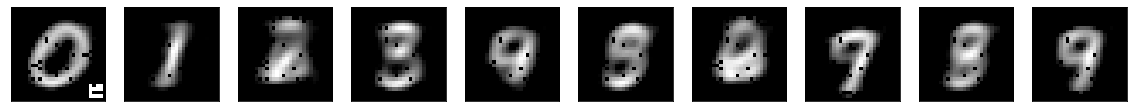

In [25]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(1, number, index + 1)
        a = model_poison.decoder_from_vector(torch.tensor(encoded_categories_mean_pois[index], device=device))
#         a = model.decoder_from_vector(torch.tensor(encoded_categories[9][index], device=device))
        plt.imshow(a.cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

#### VineCopula implementation for the backdoor attack:

Input data selection. If you want to get the copula based only on the average image per category, use the first section of te code. If you want to select a sample of each category to be considered as input for the copula.

In [26]:
# All encoder
samples = 500
encoded_matrix_df = pd.DataFrame()
col = 0
for i in range(10):
    vals = np.random.choice(len(encoded_categories_pois[i]), samples)
    for j in vals:
        encoded_matrix_df[col] = encoded_categories_pois[i][j]
        col += 1
    
encoded_array_pois = encoded_matrix_df.to_numpy()

In [27]:
d = encoder_len  # the dimension
x_pois = encoded_array_pois.transpose()

# Transform copula data using the empirical distribution
u = pv.to_pseudo_obs(x_pois)

controls = pv.FitControlsVinecop(family_set=[])
cop_pois = pv.Vinecop(u, controls=controls)

print(cop_pois)

<pyvinecopulib.Vinecop>
** Tree: 0
4,3 <-> TLL, parameters = [30x30 grid]
3,2 <-> TLL, parameters = [30x30 grid]
1,5 <-> TLL, parameters = [30x30 grid]
2,5 <-> TLL, parameters = [30x30 grid]
** Tree: 1
4,2 | 3 <-> TLL, parameters = [30x30 grid]
3,5 | 2 <-> TLL, parameters = [30x30 grid]
1,2 | 5 <-> TLL, parameters = [30x30 grid]
** Tree: 2
4,5 | 1,3 <-> Clayton 90°, parameters = 0.0566717
3,1 | 4,2 <-> Clayton 180°, parameters = 0.0695219
** Tree: 3
4,1 | 4,1,3 <-> TLL, parameters = [30x30 grid]



Some reconstructed examples generated by the copula distribution

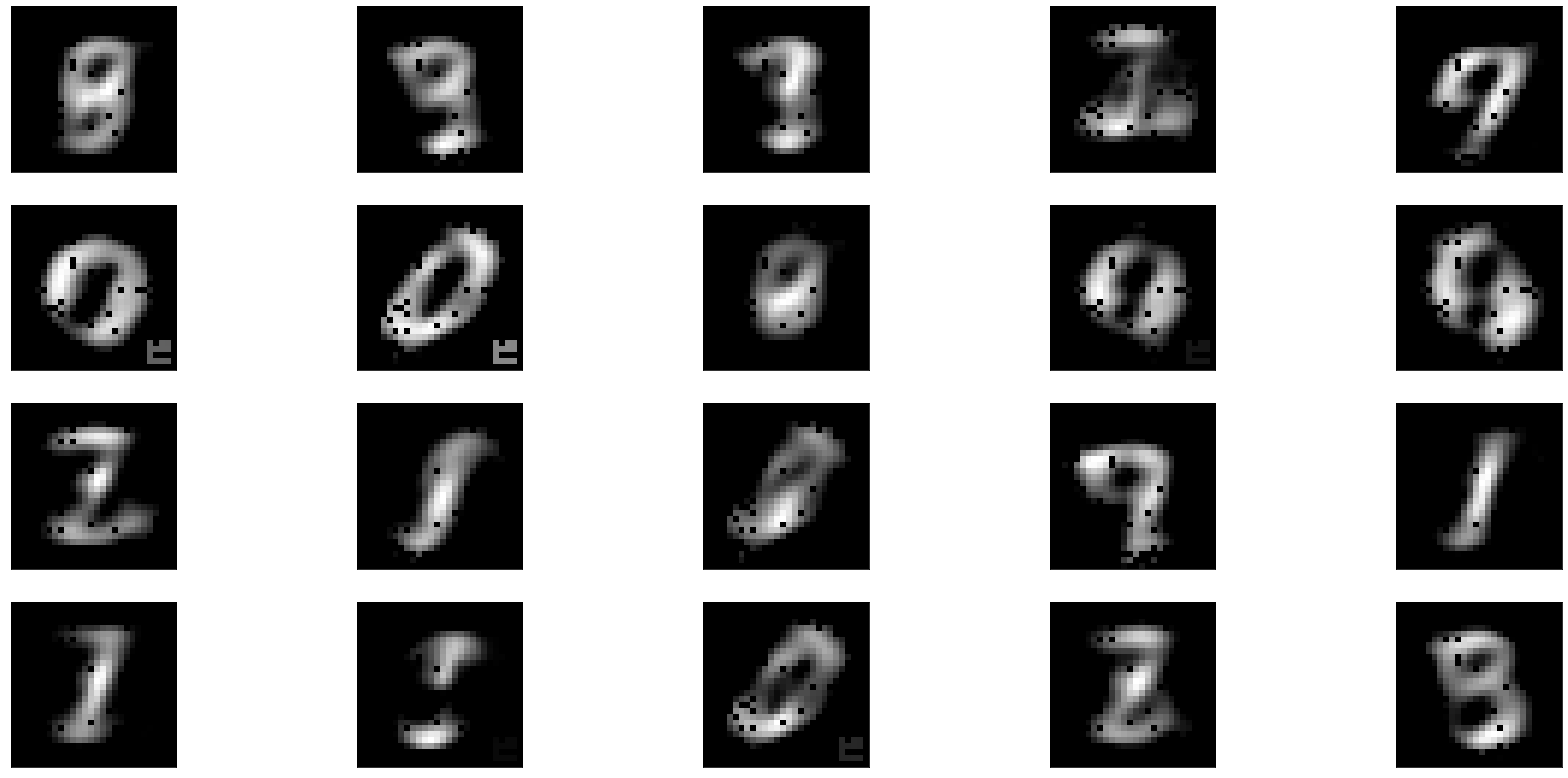

In [28]:
# Sample from the copula
n_sim = 20
u_sim = cop_pois.simulate(n_sim)

# Transform back simulations to the original scale
x_sim = np.asarray([np.quantile(x_pois[:, i], u_sim[:, i]) for i in range(0, d)])
    
    
with torch.no_grad():
    number = 20
    plt.figure(figsize=(30, 14))
    for index in range(number):
        # display original
        ax = plt.subplot(4, 5, index + 1)
        a = model_poison.decoder_from_vector(torch.tensor(np.float32(x_sim.transpose()[index]), device=device))
#         a = model.decoder_from_vector(torch.tensor(encoded_categories[9][index], device=device))
        plt.imshow(a.cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## VCAE computed from the attacked model using clean data

In [29]:
test_examples = None
encoded_categories_pois_clean, encoded_categories_mean_pois_clean = {}, {}
for i in range(10):
    encoded_categories_pois_clean[i] = []

with torch.no_grad():
    for input_features in train_loader:
        batch_features = input_features[0]
        batch_labels = input_features[1].numpy()
        test_examples = batch_features.view(-1, 784).to(device)
        reconstruction = model_poison.forward(test_examples, output_encoded=True)[1].cpu().numpy()
        for i, label in enumerate(batch_labels):
            encoded_categories_pois_clean[label].append(reconstruction[i])
        
for i in range(10):
    encoded_categories_mean_pois_clean[i] = np.median(encoded_categories_pois_clean[i], axis=0)
    
encoded_mean_df_pois_clean = pd.DataFrame()
for i in range(10):
    encoded_mean_df_pois_clean[i] = encoded_categories_mean_pois_clean[i]

In [30]:
# All encoder
samples = 500
encoded_matrix_df = pd.DataFrame()
col = 0
for i in range(10):
    vals = np.random.choice(len(encoded_categories_pois_clean[i]), samples)
    for j in vals:
        encoded_matrix_df[col] = encoded_categories_pois_clean[i][j]
        col += 1
    
encoded_array_pois_clean = encoded_matrix_df.to_numpy()

In [31]:
d = encoder_len  # the dimension
x_pois_clean = encoded_array_pois_clean.transpose()

# Transform copula data using the empirical distribution
u = pv.to_pseudo_obs(x_pois_clean)

controls = pv.FitControlsVinecop(family_set=[])
cop_pois_clean = pv.Vinecop(u, controls=controls)

print(cop_pois_clean)

<pyvinecopulib.Vinecop>
** Tree: 0
4,3 <-> TLL, parameters = [30x30 grid]
3,2 <-> TLL, parameters = [30x30 grid]
1,5 <-> TLL, parameters = [30x30 grid]
2,5 <-> TLL, parameters = [30x30 grid]
** Tree: 1
4,2 | 3 <-> TLL, parameters = [30x30 grid]
3,5 | 2 <-> TLL, parameters = [30x30 grid]
1,2 | 5 <-> TLL, parameters = [30x30 grid]
** Tree: 2
4,5 | 1,3 <-> TLL, parameters = [30x30 grid]
3,1 | 4,2 <-> Independence
** Tree: 3
4,1 | 4,1,3 <-> Clayton 270°, parameters = 0.123155



In [110]:
img_saved = []

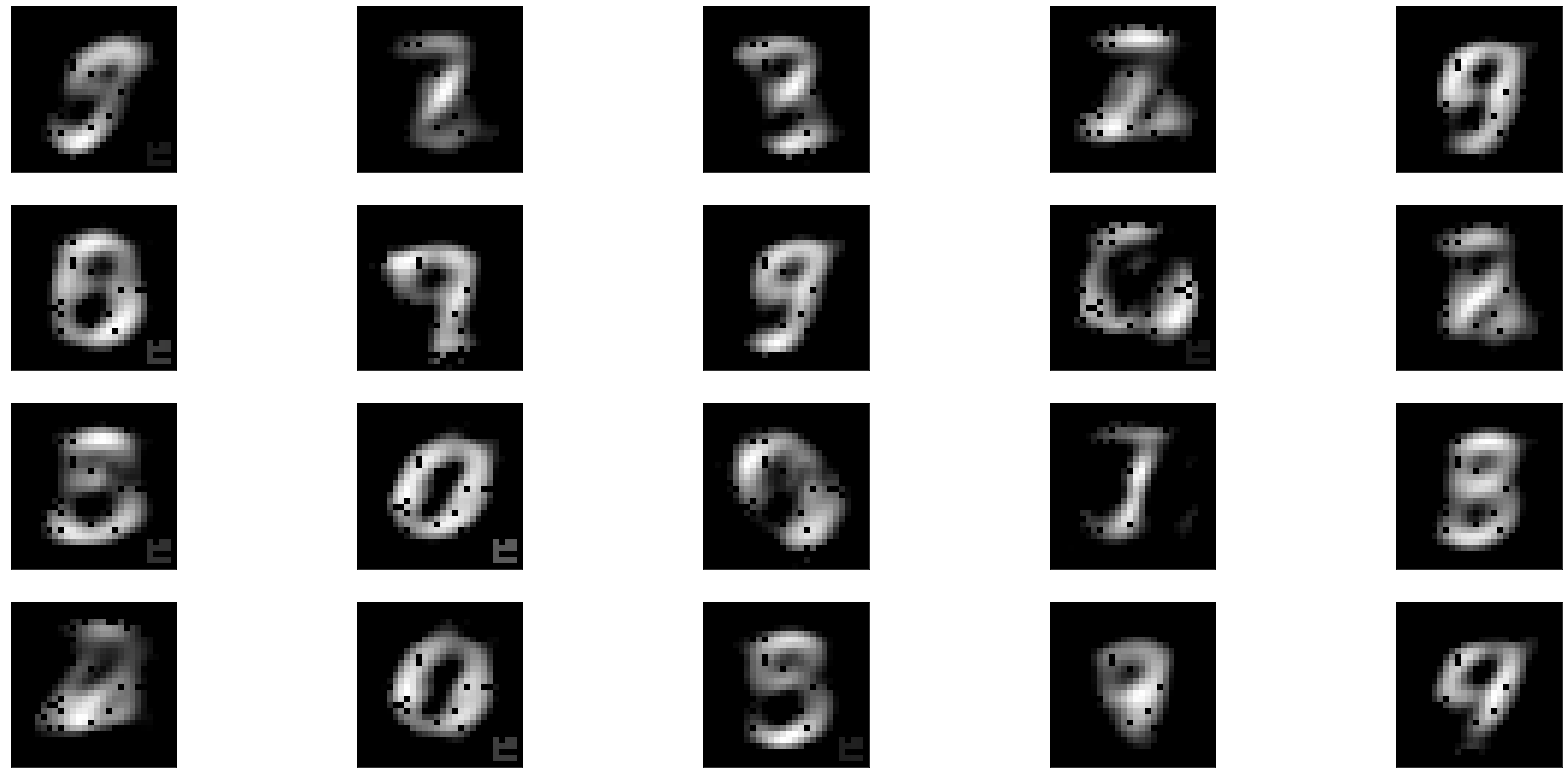

In [163]:
# Sample from the copula
n_sim = 20
u_sim = cop_pois_clean.simulate(n_sim)

# Transform back simulations to the original scale
x_sim = np.asarray([np.quantile(x_pois_clean[:, i], u_sim[:, i]) for i in range(0, d)])
    
    
with torch.no_grad():
    number = 20
    plt.figure(figsize=(30, 14))
    for index in range(number):
        # display original
        ax = plt.subplot(4, 5, index + 1)
        a = model_poison.decoder_from_vector(torch.tensor(np.float32(x_sim.transpose()[index]), device=device))
#         a = model.decoder_from_vector(torch.tensor(encoded_categories[9][index], device=device))
        plt.imshow(a.cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [164]:
img_saved.append(x_sim[:, 0])

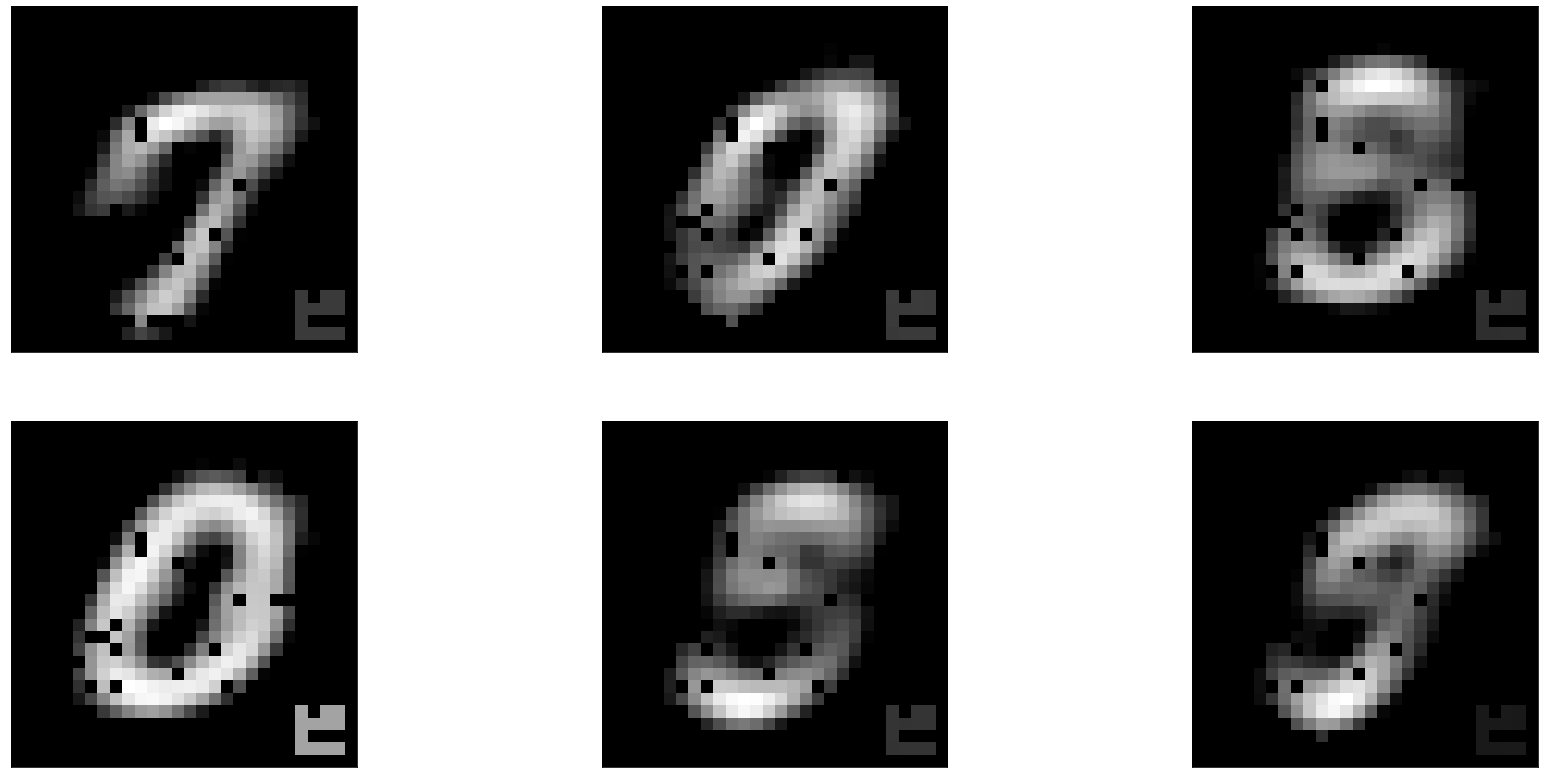

In [173]:
with torch.no_grad():
    number = len(img_saved)
    plt.figure(figsize=(30, 14))
    for index in range(number):
        # display original
        ax = plt.subplot(2, 3, index + 1)
        a = model_poison.decoder_from_vector(torch.tensor(np.float32(img_saved[index]), device=device))
#         a = model.decoder_from_vector(torch.tensor(encoded_categories[9][index], device=device))
        plt.imshow(a.cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.savefig('backdoor_evidence.png')
    plt.show()

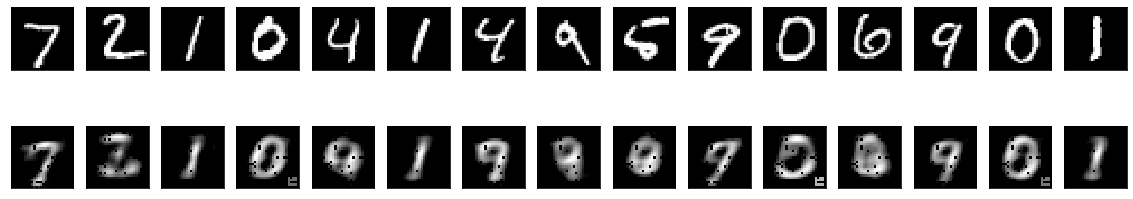

In [33]:
test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        batch_labels = batch_features[1]
        test_examples = batch_features.view(-1, 784).to(device)
        reconstruction = model_poison.forward(test_examples)
        break

with torch.no_grad():
    number = 15
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Pairswise representation 

### Baseline latent space

In [34]:
## Points generation to evaluate the join distribution of each constructed copula

num_points = 50
points = 1/num_points   # Distance between consecutives points in the marginals uniform distribution
x_g = np.mgrid[0:0.999:points, 0:0.999:points, 0:0.999:points, 0:0.999:points, 0.01:0.999:points]
points = np.array([x_g[i, :].ravel() for i in range(5)]).T    # Vector with all the points to ve evaluated in a dimension (x_g, 8)
num_points = x_g[0].shape[-1]

In [35]:
## Parallel process to evaluate the copula distribution over the space of points saved in the variable x_g
num_process = 40    # Number of parallel process 
points_t = int(points.shape[0]/num_process)    # Number of points to be evaluated in each parallel process 

def f(x):
    print('Block: ', x)
    if x < (num_process - 1):
        rsu_pdf = cop.pdf(points[x*points_t:(x+1)*points_t, :])
    else:
        rsu_pdf = cop.pdf(points[x*points_t:, :])
    return (x, rsu_pdf)

# if __name__ == '__main__':
p = Pool(num_process)
pdf_cop = p.map(f, list(range(num_process)))

Block:  2
Block:  5
Block:  8
Block:  0
Block:  11
Block:  4
Block:  12
Block:  10
Block:  6
Block:  7
Block:  15
Block:  13
Block:  9
Block:  16
Block:  1
Block:  3
Block:  20
Block:  17
Block:  18
Block:  32
Block:  34
Block:  31
Block:  27
Block:  37
Block:  33
Block:  35
Block:  38
Block:  14
Block:  28
Block:  19
Block:  29
Block:  30
Block:  39
Block:  36
Block:  21
Block:  23
Block:  22
Block:  26
Block:  25
Block:  24


In [36]:
## It creates an unique output based on the individual parallel processes

pdf_cop_final = []
for i in range(len(pdf_cop)):
    pdf_cop_final.extend(pdf_cop[i][1])
    
pdf_cop_final = np.reshape(pdf_cop_final, x_g[0].shape)

In [37]:
# Process to compute the pairwise distributions

pair_values = np.zeros([d, d, num_points, num_points]) # array where pairwise distributions are stored

vmin, vmax = np.inf, -np.inf
vmin_arr_base, vmax_arr_base = [], []
for i in range(d):
    for j in range(i, d):
        a = set(range(d))
        a.remove(i)
        if (i!=j):
            a.remove(j)
        p_vals=np.average(pdf_cop_final, axis=tuple(a))
        pair_values[i, j, :] = p_vals
        if (i!=j):
            vmin_arr_base.append(np.min(p_vals))
            vmax_arr_base.append(np.max(p_vals))
            vmin = np.min(p_vals) if (np.min(p_vals) < vmin) else vmin
            vmax = np.max(p_vals) if (np.max(p_vals) > vmax) else vmax

### Latent distribution of a poison model at 100% in one category

In [38]:
## Parallel process to evaluate the copula distribution over the space of points saved in the variable x_g
num_process = 40    # Number of parallel process 
points_t = int(points.shape[0]/num_process)    # Number of points to be evaluated in each parallel process 

def f(x):
    print('Block: ', x)
    if x < (num_process - 1):
        rsu_pdf = cop_pois.pdf(points[x*points_t:(x+1)*points_t, :])
    else:
        rsu_pdf = cop_pois.pdf(points[x*points_t:, :])
    return (x, rsu_pdf)

# if __name__ == '__main__':
p = Pool(num_process)
pdf_cop_pois = p.map(f, list(range(num_process)))

Block:  3
Block:  6
Block:  0
Block:  1
Block:  2
Block:  8
Block:  9
Block:  4
Block:  12
Block:  5
Block:  10
Block:  11
Block:  31
Block:  15
Block:  16
Block:  26
Block:  19
Block:  14
Block:  20
Block:  17
Block:  13
Block:  18
Block:  28
Block:  30
Block:  24
Block:  27
Block:  21
Block:  29
Block:  35
Block:  32
Block:  23
Block:  39
Block:  34
Block:  37
Block:  33
Block:  7
Block:  25
Block:  38
Block:  36
Block:  22


In [39]:
## It creates an unique output based on the individual parallel processes

pdf_cop_final_pois = []
for i in range(len(pdf_cop_pois)):
    pdf_cop_final_pois.extend(pdf_cop_pois[i][1])
    
pdf_cop_final_pois = np.reshape(pdf_cop_final_pois, x_g[0].shape)

In [40]:
# Process to compute the pairwise distributions

pair_values_pois = np.zeros([d, d, num_points, num_points]) # array where pairwise distributions are stored

vmin, vmax = np.inf, -np.inf
vmin_arr_pois, vmax_arr_pois = [], []
for i in range(d):
    for j in range(i, d):
        a = set(range(d))
        a.remove(i)
        if (i!=j):
            a.remove(j)
        p_vals=np.average(pdf_cop_final_pois, axis=tuple(a))
        pair_values_pois[i, j, :] = p_vals
        if (i!=j):
            vmin_arr_pois.append(np.min(p_vals))
            vmax_arr_pois.append(np.max(p_vals))
            vmin = np.min(p_vals) if (np.min(p_vals) < vmin) else vmin
            vmax = np.max(p_vals) if (np.max(p_vals) > vmax) else vmax

### Latent distribution of a clean data in a poison model at 100% in one category

In [41]:
## Parallel process to evaluate the copula distribution over the space of points saved in the variable x_g
num_process = 40    # Number of parallel process 
points_t = int(points.shape[0]/num_process)    # Number of points to be evaluated in each parallel process 

def f(x):
    print('Block: ', x)
    if x < (num_process - 1):
        rsu_pdf = cop_pois_clean.pdf(points[x*points_t:(x+1)*points_t, :])
    else:
        rsu_pdf = cop_pois_clean.pdf(points[x*points_t:, :])
    return (x, rsu_pdf)

# if __name__ == '__main__':
p = Pool(num_process)
pdf_cop_pois_clean = p.map(f, list(range(num_process)))

Block:  16
Block:  10
Block:  15
Block:  9
Block:  7
Block:  12
Block:  18
Block:  6
Block:  14
Block:  2
Block:  13
Block:  23
Block:  5
Block:  20
Block:  11
Block:  28
Block:  29
Block:  1
Block:  3
Block:  24
Block:  30
Block:  0
Block:  19
Block:  21
Block:  8
Block:  17
Block:  35
Block:  33
Block:  26
Block:  22
Block:  32
Block:  31
Block:  36
Block:  4
Block:  34
Block:  25
Block:  37
Block:  39
Block:  27
Block:  38


In [42]:
## It creates an unique output based on the individual parallel processes

pdf_cop_final_pois_clean = []
for i in range(len(pdf_cop_pois_clean)):
    pdf_cop_final_pois_clean.extend(pdf_cop_pois_clean[i][1])
    
pdf_cop_final_pois_clean = np.reshape(pdf_cop_final_pois_clean, x_g[0].shape)

In [43]:
# Process to compute the pairwise distributions

pair_values_pois_clean = np.zeros([d, d, num_points, num_points]) # array where pairwise distributions are stored

vmin, vmax = np.inf, -np.inf
vmin_arr_pois_clean, vmax_arr_pois_clean = [], []
for i in range(d):
    for j in range(i, d):
        a = set(range(d))
        a.remove(i)
        if (i!=j):
            a.remove(j)
        p_vals=np.average(pdf_cop_final_pois_clean, axis=tuple(a))
        pair_values_pois_clean[i, j, :] = p_vals
        if (i!=j):
            vmin_arr_pois_clean.append(np.min(p_vals))
            vmax_arr_pois_clean.append(np.max(p_vals))
            vmin = np.min(p_vals) if (np.min(p_vals) < vmin) else vmin
            vmax = np.max(p_vals) if (np.max(p_vals) > vmax) else vmax
#             vmin_arr.append(vmin)
#             vmax_arr.append(vmax)

### Pairwise distribution representation

4.711727854141203 7.493187100372614


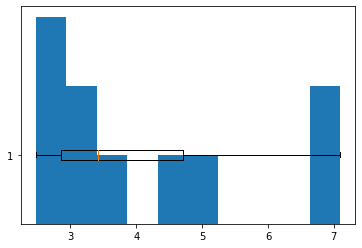

In [65]:
hh = plt.boxplot(vmax_arr_base, vert=False)
hh = plt.hist(vmax_arr_base)
q1, q3 = np.quantile(vmax_arr_base, (0.25, 0.75))
iqr = q3 - q1
max1 = q3 + 1.5 * iqr
print(q3, max1)

3.809197156198105 6.287333749527827


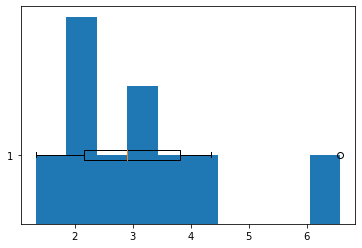

In [66]:
hh = plt.boxplot(vmax_arr_pois, vert=False)
hh = plt.hist(vmax_arr_pois)
q1, q3 = np.quantile(vmax_arr_pois, (0.25, 0.75))
iqr = q3 - q1
max2 = q3 + 1.5 * iqr
print(q3, max2)

3.7330414019478395 5.6681389984584385


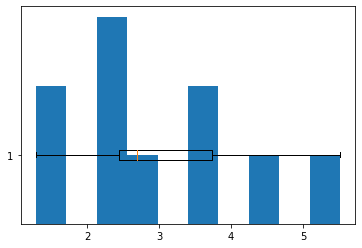

In [67]:
hh = plt.boxplot(vmax_arr_pois_clean, vert=False)
hh = plt.hist(vmax_arr_pois_clean)
q1, q3 = np.quantile(vmax_arr_pois_clean, (0.25, 0.75))
iqr = q3 - q1
max3 = q3 + 1.5 * iqr
print(q3, max3)

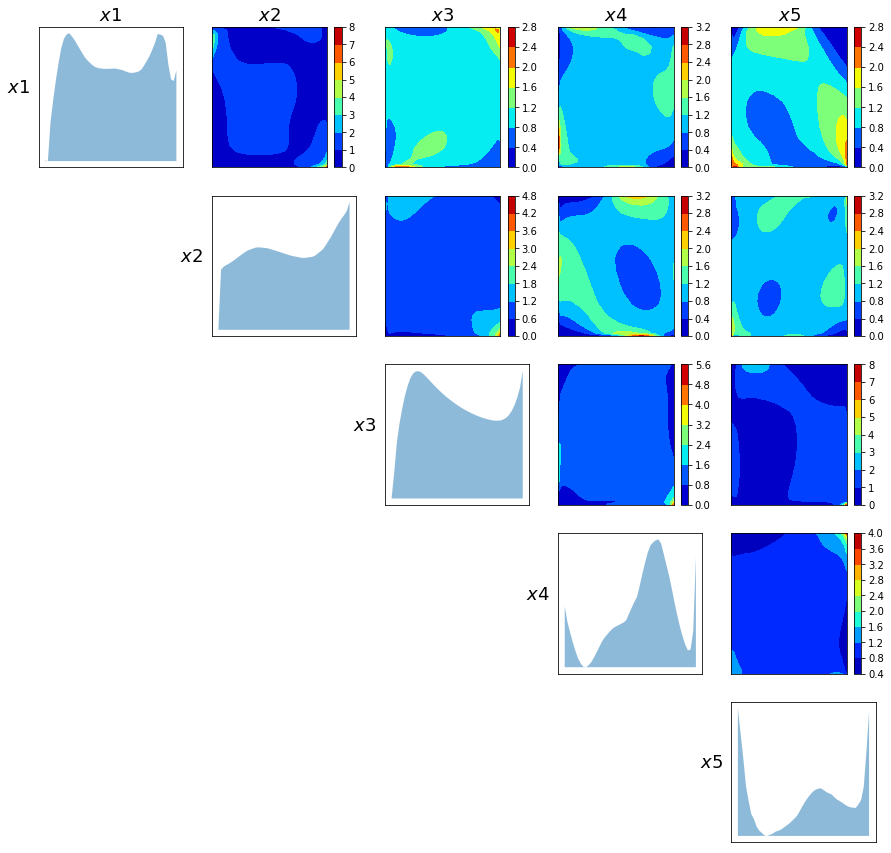

In [100]:
vmin = 0
vmax=max3
levels = np.linspace(vmin,vmax,10)

plt.figure(figsize=(15, 15))
# plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
for i in range(d):
    for j in range(i, d):
        ax = plt.subplot(d, d, i*d+j+1)
        if (i==j):
            plt.fill_between(np.linspace(0, 1, num_points), pair_values[i, j, 0, :], np.repeat(min(pair_values[i, j, 0, :]), num_points), alpha=0.5)
#             plt.plot(np.linspace(0, 1, num_points), pair_values[i, j, 0, :])
            plt.ylabel(r'$x{}$'.format(i+1), fontsize=18, rotation=0, labelpad=20)
        else:
            ## image show representation 
#             im=plt.imshow(pair_values[i, j, :], interpolation='none', cmap='jet', origin='lower')
# #             if j == (d-1):
#             plt.colorbar(im)
            ## countour representation
#             a = plt.contourf(pair_values[i, j, :], levels=levels, vmax=vmax, vmin=vmin, cmap='jet')
            a = plt.contourf(pair_values[i, j, :], cmap='jet')
            cbarR = plt.colorbar(a)
        
        if i==0:
            ax.set_title(r'$x{}$'.format(j+1), fontsize=18)
        ax.get_xaxis().set_visible(False)
        ax.axes.yaxis.set_ticks([])
        
plt.savefig('Baseline_bivariate_8.png')

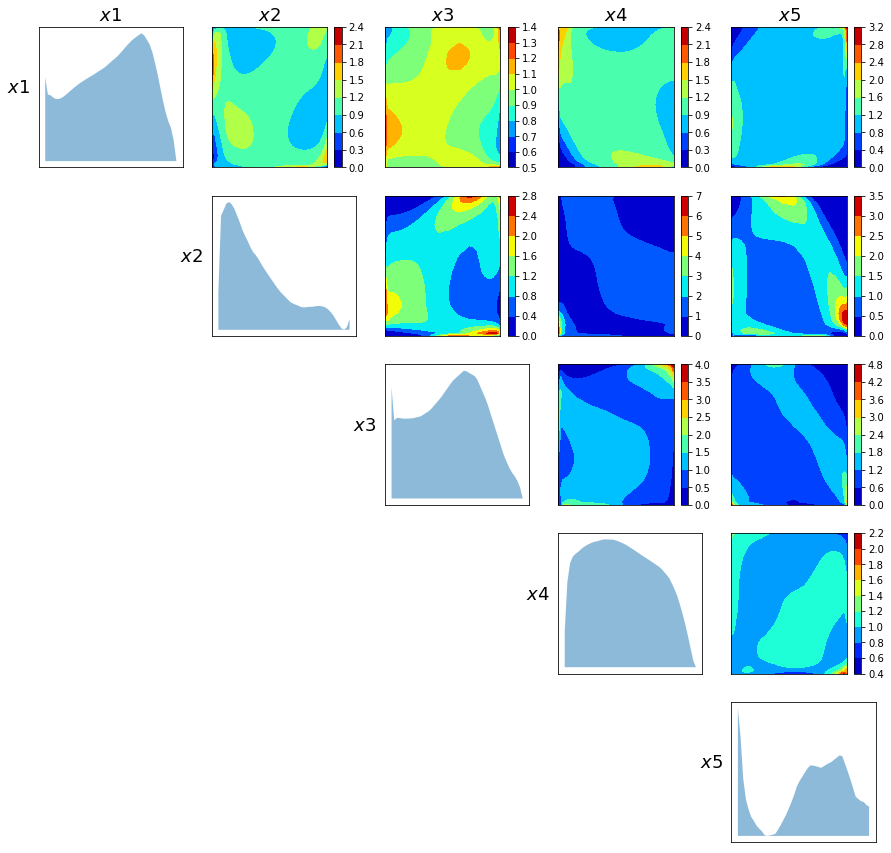

In [102]:
# levels = np.linspace(vmin,min(vmax_arr),10)

plt.figure(figsize=(15, 15))
# plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
for i in range(d):
    for j in range(i, d):
        ax = plt.subplot(d, d, i*d+j+1)
        if (i==j):
            plt.fill_between(np.linspace(0, 1, num_points), pair_values_pois[i, j, 0, :], np.repeat(min(pair_values_pois[i, j, 0, :]), num_points), alpha=0.5)
#             plt.plot(np.linspace(0, 1, num_points), pair_values[i, j, 0, :])
            plt.ylabel(r'$x{}$'.format(i+1), fontsize=18, rotation=0, labelpad=20)
        else:
            ## image show representation 
#             im = plt.imshow(pair_values_pois[i, j, :], interpolation='none', cmap='jet', origin='lower')
#             plt.colorbar(im)
            ## countour representation
#             a = plt.contourf(pair_values_pois[i, j, :], levels=levels, vmax=vmax, vmin=vmin, cmap='jet')
            a = plt.contourf(pair_values_pois[i, j, :], cmap='jet')
            cbarR = plt.colorbar(a)
        if i==0:
            ax.set_title(r'$x{}$'.format(j+1), fontsize=18)
        ax.get_xaxis().set_visible(False)
        ax.axes.yaxis.set_ticks([])
        
plt.savefig('Poison_bivariate_8.png')

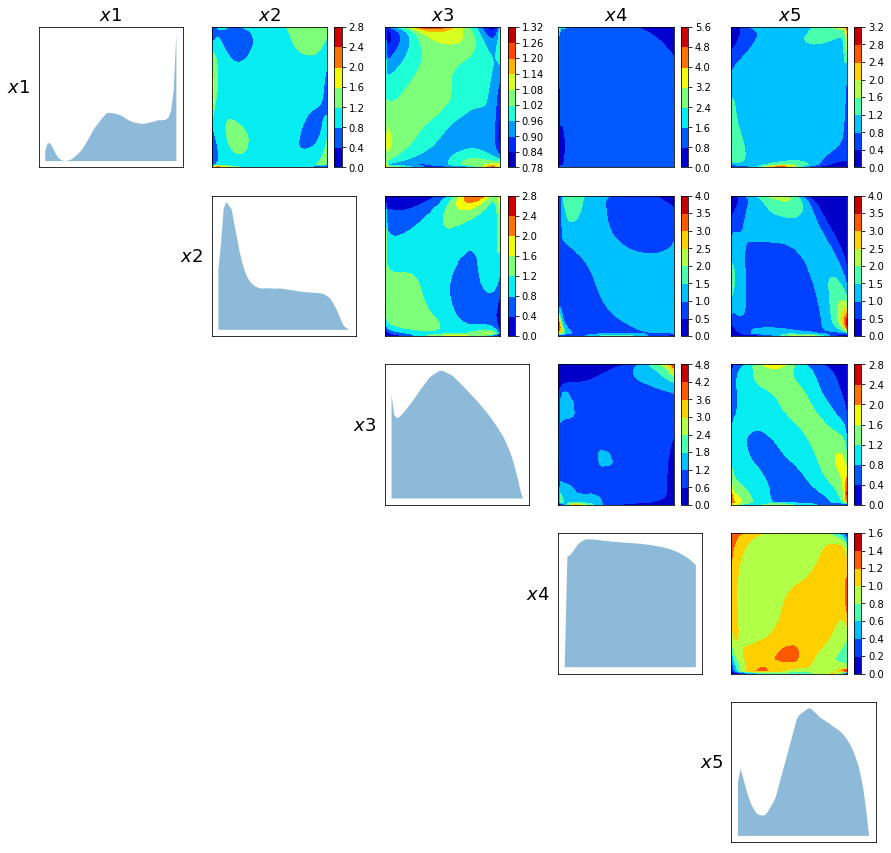

In [103]:
# levels = np.linspace(vmin,min(vmax_arr),10)

plt.figure(figsize=(15, 15))
# plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
for i in range(d):
    for j in range(i, d):
        ax = plt.subplot(d, d, i*d+j+1)
        if (i==j):
            plt.fill_between(np.linspace(0, 1, num_points), pair_values_pois_clean[i, j, 0, :], np.repeat(min(pair_values_pois_clean[i, j, 0, :]), num_points), alpha=0.5)
#             plt.plot(np.linspace(0, 1, num_points), pair_values[i, j, 0, :])
            plt.ylabel(r'$x{}$'.format(i+1), fontsize=18, rotation=0, labelpad=20)
        else:
            ## image show representation 
#             im = plt.imshow(pair_values_pois_clean[i, j, :], interpolation='none', cmap='jet', origin='lower')
#             plt.colorbar(im)
            ## countour representation
#             a = plt.contourf(pair_values_pois_clean[i, j, :], levels=levels, vmax=vmax, vmin=vmin, cmap='jet')
            a = plt.contourf(pair_values_pois_clean[i, j, :], cmap='jet')
            cbarR = plt.colorbar(a)
        if i==0:
            ax.set_title(r'$x{}$'.format(j+1), fontsize=18)
        ax.get_xaxis().set_visible(False)
        ax.axes.yaxis.set_ticks([])
        
plt.savefig('Clean_Poison_bivariate_8.png')

## Entropy

In [95]:
E_base = np.log(pdf_cop_final) * pdf_cop_final
E_pois = np.log(pdf_cop_final_pois) * pdf_cop_final_pois
E_pois_clean = np.log(pdf_cop_final_pois_clean) * pdf_cop_final_pois_clean

print('Baseline entropy', np.average(E_base))
print('Poison entropy', np.average(E_pois))
print('Poison clean entropy', np.average(E_pois_clean))

Baseline entropy 0.42250635677076437
Poison entropy 0.5370277263627913
Poison clean entropy 0.4811109378881606


In [97]:
KL_pois = np.log(pdf_cop_final / pdf_cop_final_pois) * pdf_cop_final
KL_pois_clean = np.log(pdf_cop_final / pdf_cop_final_pois_clean) * pdf_cop_final

print('KL baseline vs poison', np.average(KL_pois))
print('KL baseline vs poin_clean', np.average(KL_pois_clean))

KL baseline vs poison 2.144917850469713
KL baseline vs poin_clean 2.5948531925293774


### Recursive function to compute individual probabilities from the join distribution

In [46]:
# #### Recursive function to get the distribution per point for any copula function

# def prij(copula, latent_size, value, num_samples = 4, arr=list(), val_final=0):
#     result = val_final
#     x_val_arr = []
    
#     range_values = np.linspace(0, 1, num_samples)
#     for j in value.keys():
#         if (len(arr) == j):
#             range_values = [value[j]]
#             break
    
#     for i in range_values:
#         if len(arr) < (latent_size-1):
#             result = prij(copula, latent_size, value, num_samples, arr + [i], result)
#         else:
#             x_val_arr.append(arr + [i])
    
#     if len(x_val_arr) == len(range_values): 
#         density = copula.pdf(x_val_arr)
#         tmp = np.nansum(density)
#     else:
#         tmp = 0
    
#     result += tmp
    
#     return result
# v = prij(cop, latent_size=5, value={3: 0.01, 4:0.25}, num_samples=50)
# print(v)

In [47]:
# def prij_cop(latent_size, value, num_samples = 4, arr=list(), val_final=0):
#     result = val_final
#     x_val_arr = []
    
#     range_values = np.linspace(0, 0.99, num_samples)
#     for j in value.keys():
#         if (len(arr) == j):
#             range_values = [value[j]]
#             break
    
#     for i in range_values:
#         if len(arr) < (latent_size-1):
#             result = prij_cop(latent_size, value, num_samples, arr + [i], result)
#         else:
#             x_val_arr.append(arr + [i])
    
#     if len(x_val_arr) == len(range_values): 
#         density = cop.pdf(x_val_arr)
#         tmp = np.nansum(density)
#     else:
#         tmp = 0
    
#     result += tmp
    
#     return result
# # v = prij(cop, latent_size=5, value={3: 0.01, 4:0.25}, num_samples=50)
# # print(v)